http://hunkim.github.io/ml/

# OpenAI Gym

In [1]:
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display

def display_frames_as_gif(frames):
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    display(display_animation(anim, default_mode='once'))

In [2]:
import gym
env = gym.make('CartPole-v0')
env.reset()
done = False
frames = []
while not done:
    frames.append(env.render(mode='rgb_array'))
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    if done:
        env.render(close=True)

[2017-05-31 18:59:44,119] Making new env: CartPole-v0



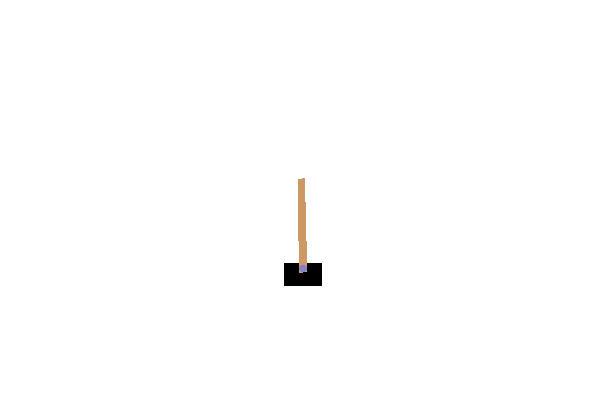
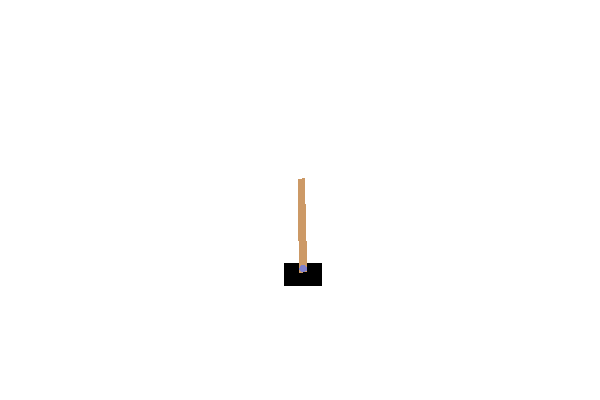
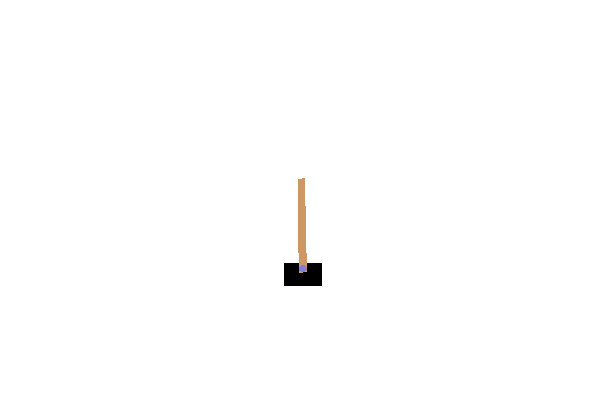
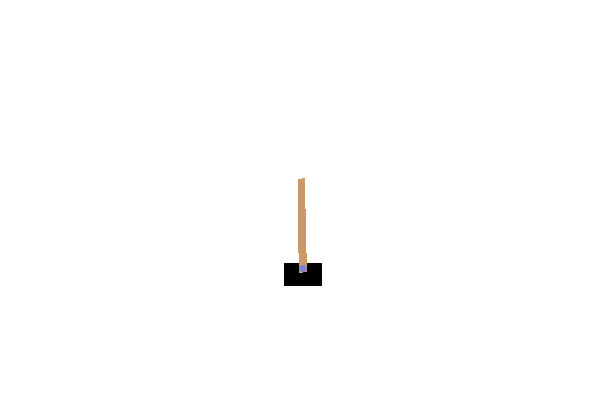
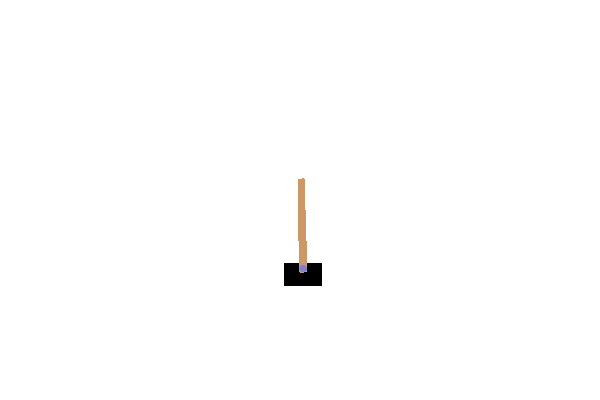
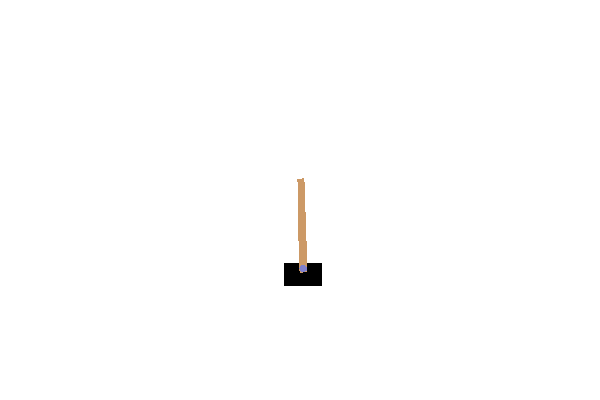
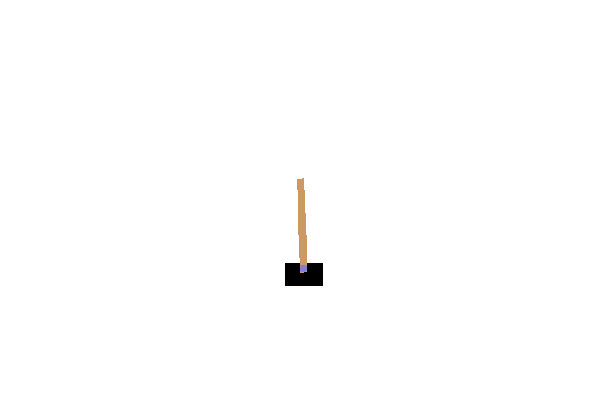
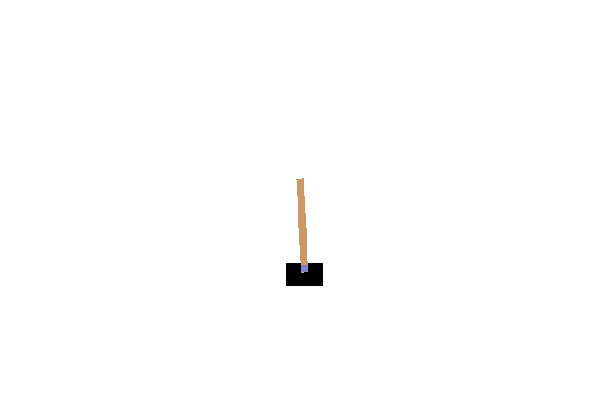
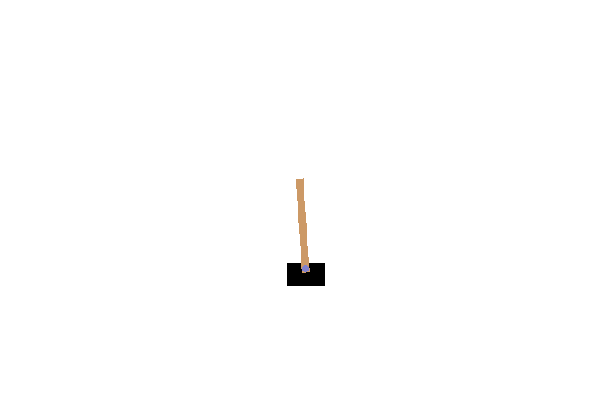
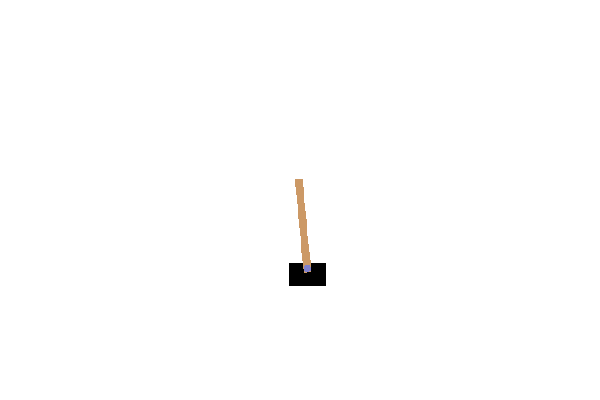
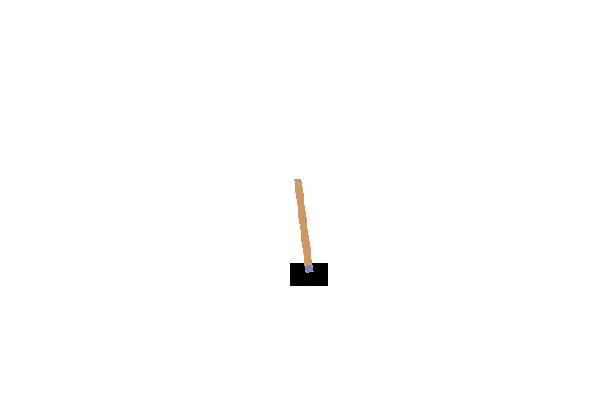
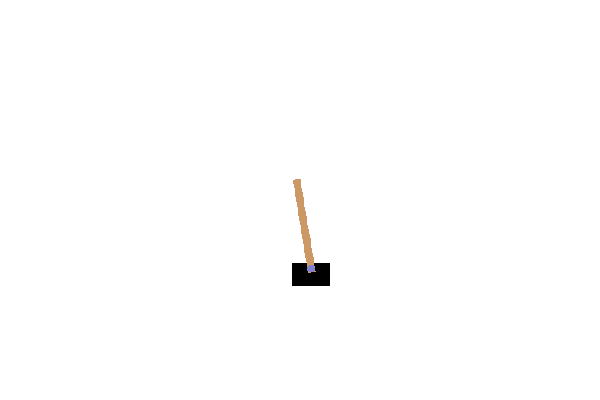
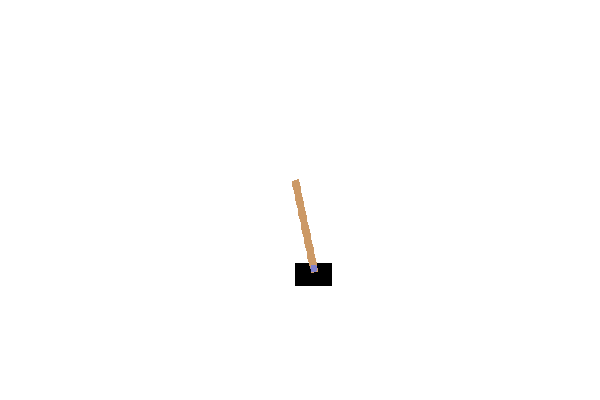

In [3]:
display_frames_as_gif(frames)

# Q-Learning

- For each $s, a$ initialize table entry $Q(s, a) \gets 0$
- Do forever: 
  - Select action $a$ and execute it
  - Receive immediate reward $r$
  - Observe new state $s'$
  - Update table $Q(s, a) \gets r + \underset{a'}\max{Q(s', a')}$
  - $s \gets s'$

In [4]:
import random

import gym
from gym.envs.registration import register
import numpy as np

def rargmax(vector):
    m = np.amax(vector)
    indices = np.nonzero(vector == m)[0]
    return random.choice(indices)

In [5]:
register(
    id='FrozenLake-v3',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '4x4', 'is_slippery': False}
)
env = gym.make('FrozenLake-v3')
Q = np.zeros([env.observation_space.n, env.action_space.n])
env.render()    # start, frozen, hole, goal

[2017-05-31 18:59:45,738] Making new env: FrozenLake-v3



SFFF
FHFH
FFFH
HFFG


In [6]:
num_episodes = 1000
for i in range(num_episodes):
    state = env.reset()
    done = False
    while not done:
        action = rargmax(Q[state, :])
        _state, reward, done, _ = env.step(action)
        Q[state, action] = reward + np.max(Q[_state, :])
        state = _state
print Q    # left, down, right, up

[[ 0.  1.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  0.]]
